<a href="https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/TCSI_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCSI Potential Cost Demonstration: Notebook
Author: John Hogland 6/29/2022

install packages on Colab

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install raster_tools
!pip install py3dep
!pip install osmnx
!pip install ipywidgets
!pip install nest-asyncio

## Estimate Potential Costs for ACCEL using raster_tools

In this notebook we will explore how we can estimate potential treatment costs for the Sierra study area using a Jupyter Notebook and ipywidgets.

note book requirements: 
- raster_tools - https://pypi.org/project/raster-tools/



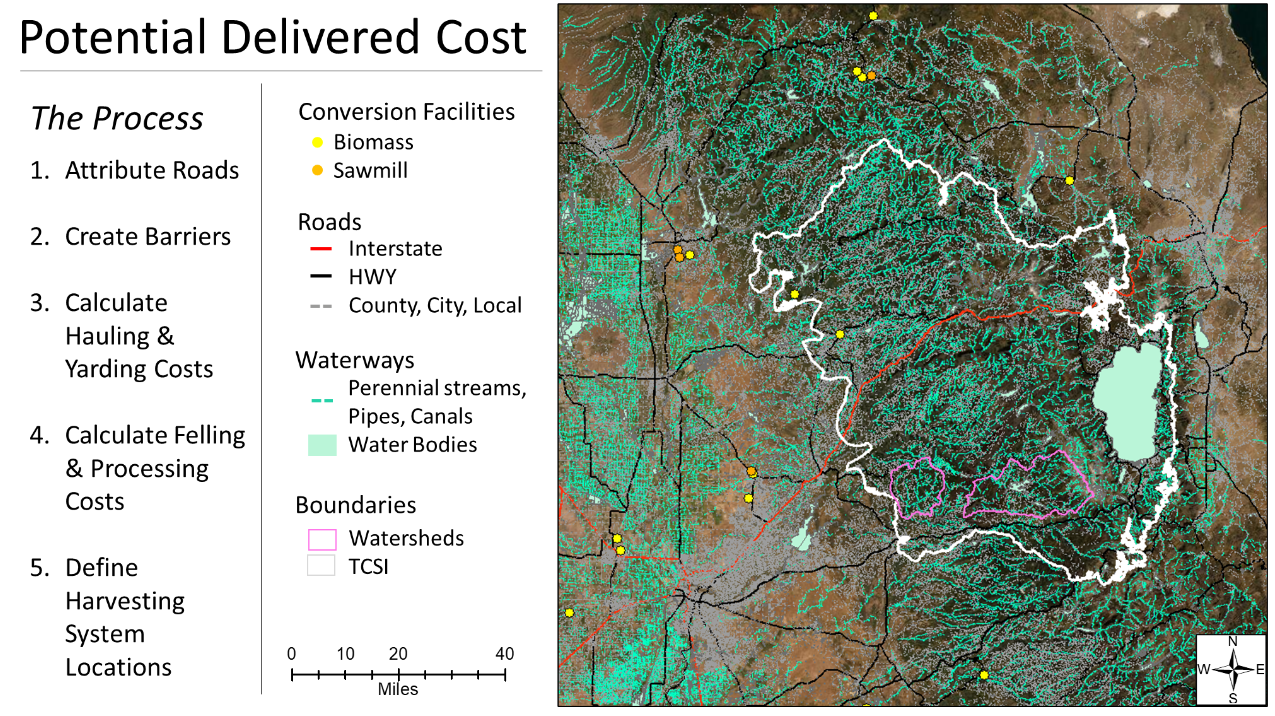

## The Data
The data will be extracted from open street maps and USGS 3dep and consist of base Raster and Vector datasets that we will be using throughout the example:
- elevation (raster): elevation surface units meters (3dep)
- roads (vector): Open Street Map roads based on Tiger Lines (OSM)
- streams (vector): Open Street Map streams based on NHD (OSM)
- water bodies (vector): OSM water bodies
- sawmills (vector): location of the sawmill (povided by Lisa)
- biomass facilities (vector): location of biomass facilities (provided by Lisa)
- Study area extent (vector): Study area boundary (provided by Pat)


In [ ]:
# only need to run once
import gdown, zipfile

url = r"https://drive.google.com/file/d/12AIsXsFh6wSWsxl-C7KrKnMvr1tQ_om4/view?usp=sharing"
outfl = r".\TCSI.zip"
gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)

with zipfile.ZipFile(outfl, "r") as zip_ref:
    zip_ref.extractall(".")

# The Process
We will be using a series of sliders that define various rates for multiple harvesting system and then run the delivered cost model. Within the delivered cost model, the following analyses will be performed: 
1. Subset and attribute OSM roads with speed based on criteria in **Table 1**.
2. Create barrier to offroad motion for off road analysis using a subset of OSM streams and water bodies.
3. Estimate potential on road and offroad cost surfaces for each harvesting system using interactive sliders based on the criteria in **Table 2**.
4. Create felling and processing surfaces and add potential costs.
5. Specify where harvesting systems occur and subset system costs to those locations.
6. Create final spatial representations of the potential cost to treat each raster cell on a dollar per CCF basis.
7. Save final raster surfaces.

**Table 1**. Road segment travel speed by [OSM highway](https://wiki.openstreetmap.org/wiki/Key:highway) class types.

|Query|Speed (MPH)|
|:-|:-:|
|Residential|25|
|Unclassified|15|
|Tertiary|35|
|Secondary|45|
|Primary|55|
|Trunk|55|
|Motorway|65|

**Table 2**. Criteria used to spatially define harvesting systems and treatment costs. Machine rate of travel, and capacity estimates derived from meetings with Lisa Ball, Jacob Baker, Michael Jow, and Brian McCrory.

|Component|System|Rate|Rate of travel|Payload|Where it can occur|
|:-:|:-:|:-:|:-:|:-:|:-:|
|       |Rubber tire skidder|\$165/hr|1.5 MPH|1.25 CCF|Slopes <= 35% and Next to Roads ( distance < 460 m from a road).|
|Offroad|Skyline|\$400/hr|2.0 MPH|1.04 CCF|Slopes > 35% and within 305 m of a road.|
|       |Helicopter|\$8,000/hr|2.4 MPH|1.67 CCF|Areas not covered by the other two and distance < 915 m from landing area.|
|Felling|Feller buncher|\$15/CCF|NA|NA|Slopes <= 35%|
|       |Hand Felling|\$27/CCF|NA|NA|Slopes > 35%|
|Processing|Delimbing, cutting to length, chipping, and loading|\$56/CCF|NA|NA|NA|
|On road|Log Truck|\$98/hour|Table 1|12.25 CCF|NA|
|Additional Treatments|Hand Treatment|\$2470/acre|NA|NA|Forested Areas|
|       |Prescribed fire|\$2470/acre|NA|NA|Forested Areas|

# User Defined Rates (Table 2) Via Ipywidget Sliders

## The GUI
This gui will create a user interface that allows users to specifiy the location of the data, various rates, and will create multiple new raster surfaces. By default outputs will consist of a series of raster surfaces depicting costs by unit of measure (e.g., \$/CCF or Ton). Optional surfaces can also be created by checking the Optional Surfaces checkbox. All raster surfaces will be saved to the working directory with the following naming convention:

Defaults-
- biomass_cost.tif; the cost for all harvesting systems to remove biomass material from the forest and transport it to a conversion facility given the defined operational boundaries (\$/unit)
- sawlog_cost.tif; the cost for all harvesting systems to remove sawlog material from the forest and transport it to a conversion facility given the defined operational boundaries (\$/unit)
- add_treatment_cost.tif; additional cost of implementing treatments like hand felling and prescribed fire (\$)

Optional-
- cable_bio_cost.tif; the \$/unit cost for skyline systems to remove biomass material
- cable_saw_cost.tif; the \$/unit cost for skyline systems to remove sawlog material
- skidder_bio_cost.tif; the \$/unit cost for rubber tire skidder systems to remove biomass material
- skidder_saw_cost.tif; the \$/unit cost for rubber tire skidder systems to remove sawlog material
- helicopter_bio_cost.tif; the \$/unit cost for helicopter systems to remove biomass material
- helicopter_saw_cost.tif; the \$/unit cost for helicopter systems to remove sawlog material
- potential_harv_system.tif; the spatial location of each harvesting system (1:skidder, 2:skyline, 3:helicopter)
- prescribed_fire_cost.tif; the cell cost of implementing prescribed fire (\$)
- hand_treatment_cost.tif; the cell cost of implementing hand treatments (\$)

### To open the user interface run the next cell 
Don't forget to click the run button after specifying values.

In [ ]:
# @title
import ipywidgets
import potcost

# widgets
style = {"description_width": "initial"}

wks_path = ipywidgets.widgets.Text(
    value="./data",
    placeholder="Type something",
    description="Workspace Path:",
    disabled=False,
    style=style,
)
study_area_name = ipywidgets.widgets.Text(
    value="StudyArea",
    placeholder="Type something",
    description="Study Area File Name:",
    disabled=False,
    style=style,
)
sawmill_name = ipywidgets.widgets.Text(
    value="Sawmills",
    placeholder="Type something",
    description="Sawmill (Vector) File Name:",
    disabled=False,
    style=style,
)
biomass_name = ipywidgets.widgets.Text(
    value="BiomassFacilities",
    placeholder="Type something",
    description="Biomass (Vector) File Name:",
    disabled=False,
    style=style,
)

tr_s = ipywidgets.widgets.FloatSlider(
    value=1.5,
    min=1.0,
    max=5.0,
    step=0.1,
    description="RT Skidder Speed (MPH):",
    style=style,
)
cb_s = ipywidgets.widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=5.0,
    step=0.1,
    description="Skyline Speed (MPH):",
    style=style,
)
hl_s = ipywidgets.widgets.FloatSlider(
    value=2.4,
    min=1.0,
    max=5.0,
    step=0.1,
    description="Helicopter Speed (MPH):",
    style=style,
)

tr_d = ipywidgets.widgets.FloatSlider(
    value=165,
    min=150,
    max=200,
    step=1,
    description="RT Skidder ($/hour):",
    style=style,
)
cb_d = ipywidgets.widgets.FloatSlider(
    value=400,
    min=300,
    max=500,
    step=1,
    description="Skyline ($/hour):",
    style=style,
)
hl_d = ipywidgets.widgets.FloatSlider(
    value=8000,
    min=5000,
    max=10000,
    step=10,
    description="Helicopter ($/hour):",
    style=style,
)
fb_d = ipywidgets.widgets.FloatSlider(
    value=15,
    min=10,
    max=25,
    step=1,
    description="Fellerbuncher ($/CCF):",
    style=style,
)
hf_d = ipywidgets.widgets.FloatSlider(
    value=27,
    min=10,
    max=40,
    step=1,
    description="Hand Felling ($/CCF):",
    style=style,
)
pr_d = ipywidgets.widgets.FloatSlider(
    value=56,
    min=30,
    max=70,
    step=1,
    description="Processing ($/CCF):",
    style=style,
)
ha_d = ipywidgets.widgets.FloatSlider(
    value=98,
    min=70,
    max=120,
    step=1,
    description="Hauling ($/hour):",
    style=style,
)
ht_d = ipywidgets.widgets.FloatSlider(
    value=2470,
    min=0,
    max=4000,
    step=5,
    description="Hand Treatment ($/acre):",
    style=style,
)
pf_d = ipywidgets.widgets.FloatSlider(
    value=2470,
    min=0,
    max=4000,
    step=5,
    description="Prescribed Fire ($/acre):",
    style=style,
)

tr_p = ipywidgets.widgets.FloatSlider(
    value=1.25,
    min=1.0,
    max=5.0,
    step=0.1,
    description="RT Skidder Payload (CCF):",
    style=style,
)
cb_p = ipywidgets.widgets.FloatSlider(
    value=1.04,
    min=0.5,
    max=5.0,
    step=0.1,
    description="Skyline Payload (CCF):",
    style=style,
)
hl_p = ipywidgets.widgets.FloatSlider(
    value=1.67,
    min=1.0,
    max=5.0,
    step=0.1,
    description="Helicopter Payload (CCF):",
    style=style,
)
lt_p = ipywidgets.widgets.FloatSlider(
    value=12.25,
    min=5.0,
    max=20.5,
    step=0.1,
    description="Log Truck Payload (CCF):",
    style=style,
)

cb_o = ipywidgets.widgets.Checkbox(
    value=False,
    description="Create Optional surfaces",
    disabled=False,
    indent=False,
)

# optional widgets
roads_name = ipywidgets.widgets.Text(
    value="",
    placeholder="Name or path of feature class",
    description="Optional Roads (Vector) File Name:",
    disabled=False,
    style=style,
)
barriers_name = ipywidgets.widgets.Text(
    value="",
    placeholder="Name or path of feature class",
    description="Optional Barrier (Vector) File Name:",
    disabled=False,
    style=style,
)


interact_calc = ipywidgets.interact.options(manual=True, manual_name="Run")


@interact_calc(
    wks_path=wks_path,
    study_area_name=study_area_name,
    sawmill_name=sawmill_name,
    biomass_name=biomass_name,
    tr_s=tr_s,
    cb_s=cb_s,
    hl_s=hl_s,
    tr_d=tr_d,
    cb_d=cb_d,
    hl_d=hl_d,
    fb_d=fb_d,
    hf_d=hf_d,
    pr_d=pr_d,
    ha_d=ha_d,
    ht_d=ht_d,
    pf_d=pf_d,
    tr_p=tr_p,
    cb_p=cb_p,
    hl_p=hl_p,
    lt_p=lt_p,
    cb_o=cb_o,
    roads_name=roads_name,
    barriers_name=barriers_name,
)
def delv_cost(
    wks_path=None,
    study_area_name=None,
    sawmill_name=None,
    biomass_name=None,
    tr_s=None,
    cb_s=None,
    hl_s=None,
    tr_d=None,
    cb_d=None,
    hl_d=None,
    fb_d=None,
    hf_d=None,
    pr_d=None,
    ha_d=None,
    ht_d=None,
    pf_d=None,
    tr_p=None,
    cb_p=None,
    hl_p=None,
    lt_p=None,
    cb_o=None,
    roads_name=None,
    barriers_name=None,
):
    potcost.sk_r = tr_s * 1.609344  # converts to kph
    potcost.cb_r = cb_s * 1.609344  # converts to kph
    potcost.hl_r = hl_s * 1.609344  # converts to kph
    potcost.sk_d = tr_d
    potcost.cb_d = cb_d
    potcost.hl_d = hl_d
    potcost.fb_d = fb_d
    potcost.hf_d = hf_d
    potcost.pr_d = pr_d
    potcost.lt_d = ha_d
    potcost.ht_d = ht_d * 0.40468564  # converts to ha
    potcost.pf_d = pf_d * 0.40468564  # converts to ha
    potcost.sk_p = tr_p
    potcost.cb_p = cb_p
    potcost.hl_p = hl_p
    potcost.lt_p = lt_p
    potcost.cb_o = cb_o

    if wks_path != "":
        potcost.wks = wks_path
    if study_area_name != "":
        potcost.study_area_path = study_area_name
    if sawmill_name != "":
        potcost.lyr_sawmill_path = sawmill_name
    if biomass_name != "":
        potcost.lyr_biomass_path = biomass_name
    # optional
    if roads_name != "":
        potcost.lyr_roads_path = roads_name
    if barriers_name != "":
        potcost.lyr_barriers_path = barriers_name

    potcost.run()

    return